### Example plots

In [1]:
import functions as fnc
import numpy as np
import sys
import verde as vd
import harmonica as hm
from choclo.point import gravity_u as pointgrav
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from functions import ProlateEllipsoid, ellipsoid_magnetics
np.set_printoptions(threshold=sys.maxsize)
H0 = np.array([5, 5, 5])

In [2]:
u = (55_000, 0.0, 90.0)
type(u)

igrf = hm.magnetic_angles_to_vec(55_000, 0.0, 90.0)
print(igrf)

(55000.0, 3.3677786976552213e-12, -0.0)


In [3]:
def sphere_magnetic(coordinates, radius, center, magnetization):
    """
    Compute the magnetic field generated by a sphere with constant magnetization.

    The field inside the sphere is uniform. Outside the sphere it's equivalent 
    to the dipole field.

    Parameters
    ----------
    coordinates : tuple of floats or arrays
        Coordinates of the observation points in the following order:
        easting, northing, upward.
    radius : float
        Radius of the sphere.
    center : tuple of floats
        Coordinates of the center of the sphere in the same order as the 
        ``coordinates``.
    magnetization : tuple of floats
        Magnetization vector of the sphere.

    Returns
    -------
    be, bn, bu : arrays
        Three components of the magnetic field on the observation points in nT.
    """
    # Ravel the coordinates into 1d arrays
    cast = np.broadcast(*coordinates)
    easting, northing, upward = tuple(np.asarray(c).ravel() for c in coordinates)

    # Get the coordinates of the observation points in a coordinate system 
    # located in the center of the sphere
    x, y, z = (easting - center[0], northing - center[1], upward - center[2])

    # Allocate arrays for the resulting magnetic field
    be, bn, bu = tuple(np.zeros(cast.size) for _ in range(3))

    # Compute the internal magnetic field in nT.
    magnetization = np.asarray(magnetization)
    inside = (x**2 + y**2 + z**2) <= radius**2
    be[inside] += 2 / 3 * mu_0 * magnetization[0] * 1e9
    bn[inside] += 2 / 3 * mu_0 * magnetization[1] * 1e9
    bu[inside] += 2 / 3 * mu_0 * magnetization[2] * 1e9

    # Compute the external magnetic field (a dipole field) in nT.
    # Get the magnetic moment of the equivalent dipole
    mag_moment = 4/3 * np.pi * radius**3 * magnetization
    be_out, bn_out, bu_out = hm.dipole_magnetic(
        (easting[~inside], northing[~inside], upward[~inside]), 
        center, 
        mag_moment,
        field="b",
    )
    be[~inside] = be_out
    bn[~inside] = bn_out
    bu[~inside] = bu_out

    be, bn, bu = tuple(b.reshape(cast.shape) for b in (be, bn, bu))
    return be, bn, bu



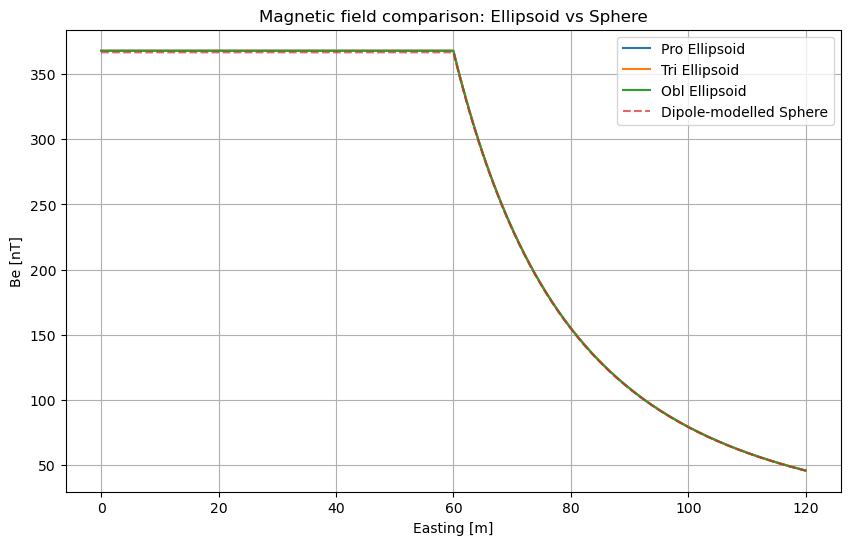

Prolate internal =  367.91734017784074
Oblate internal =  367.8686117419964
Triaxial internal =  367.89663094896565
True sphere =  366.66666666666663


In [4]:
from scipy.constants import mu_0

k = 0.01
b0 = np.array(hm.magnetic_angles_to_vec(55_000, 0.0, 90.0))  
H0_Am = b0 * 1e-9 / mu_0
M = k * H0_Am
# Define ellipsoid (make it nearly a sphere)
# ------------------------------------------

pro_ellipsoid = ProlateEllipsoid(a=60, b=59.99, yaw=0, pitch=0, centre=(0, 0, 0))
tri_ellipsoid = fnc.TriaxialEllipsoid(a=60, b=59.999, c=59.998, yaw = 0, pitch=0, roll=0, centre=(0, 0, 0))
obl_ellipsoid = fnc.OblateEllipsoid(a=59.99, b=60, yaw = 0, pitch=0, centre=(0, 0, 0))

# Define observation points along easting
# ---------------------------------------
easting = np.linspace(0, 2 * 60, 501)
northing, upward = np.zeros_like(easting), np.zeros_like(easting)
coordinates = tuple(np.atleast_2d(c) for c in (easting, northing, upward))

# Compute magnetic field for ellipsoid
# ------------------------------------
be, bn, bu = ellipsoid_magnetics(coordinates, pro_ellipsoid, k, (55_000, 0.0, 90.0), field="b")
be = be.ravel()

be1, bn1, bu1 = ellipsoid_magnetics(coordinates, tri_ellipsoid, k, (55_000, 0.0, 90.0), field="b")
be1 = be1.ravel()
#
be2, bn2, bu2 = ellipsoid_magnetics(coordinates, obl_ellipsoid, k, (55_000, 0.0, 90.0), field="b")
be2 = be2.ravel()
# Compute magnetic field for a sphere (analytic)
# ----------------------------------------------  
b_e, b_n, b_u = sphere_magnetic(coordinates, radius=60, center=(0, 0, 0), magnetization= M)
b_e = b_e.ravel()

# Plot comparison
# ---------------
plt.figure(figsize=(10, 6))
plt.plot(easting, be, label="Pro Ellipsoid")
plt.plot(easting, be1, label="Tri Ellipsoid")
plt.plot(easting, be2, label="Obl Ellipsoid")

plt.plot(easting, b_e, '--', label="Dipole-modelled Sphere", alpha=0.7)
plt.xlabel("Easting [m]")
plt.ylabel("Be [nT]")
plt.legend()
plt.title("Magnetic field comparison: Ellipsoid vs Sphere")
plt.grid(True)
plt.show()
print('Prolate internal = ', be[0]) 
print('Oblate internal = ', be2[0]) 
print('Triaxial internal = ', be1[0])
print('True sphere = ', b_e[0])

In [5]:
k = 0.1
b0 = np.array(hm.magnetic_angles_to_vec(55_000, 0.0, 90.0))  
h0_Am = b0 * 1e-9 / mu_0
M = k * h0_Am
# Define ellipsoid (make it nearly a sphere)
# ------------------------------------------


tri_ellipsoid_5 = fnc.TriaxialEllipsoid(a=60, b=59.999, c=59.998, yaw = 0, pitch=0, roll=0, centre=(0, 0, 0))

# Define observation points along easting
# ---------------------------------------
easting = np.linspace(0, 2 * 60, 501)
northing, upward = np.zeros_like(easting), np.zeros_like(easting)
coordinates = tuple(np.atleast_2d(c) for c in (easting, northing, upward))

# Compute magnetic field for ellipsoid
# ------------------------------------
be5, _, _ = ellipsoid_magnetics(coordinates, pro_ellipsoid, 5, (55_000, 0.0, 90.0), field="b")
be5 = be5.ravel()

be1,  _, _ = ellipsoid_magnetics(coordinates, tri_ellipsoid, 1, (55_000, 0.0, 90.0), field="b")
be1 = be1.ravel()
#
be_01,  _, _ = ellipsoid_magnetics(coordinates, tri_ellipsoid, 0.1, (55_000, 0.0, 90.0), field="b")
be_01 = be_01.ravel()

be_001, _, _ = ellipsoid_magnetics(coordinates, tri_ellipsoid, 0.01, (55_000, 0.0, 90.0), field="b")
be_001 = be_001.ravel()

# Compute magnetic field for a sphere (analytic)
# ----------------------------------------------  
b_e, b_n, b_u = sphere_magnetic(coordinates, radius=60, center=(0, 0, 0), magnetization= M)
b_e = b_e.ravel()

# Plot comparison
# ---------------
#plt.figure(figsize=(10, 6))
#
#plt.plot(easting, be5, label="k=5")
#plt.plot(easting, be1, label="k=1")
#plt.plot(easting, be_01, label="k=0.1")
#plt.plot(easting, be_001, label="k=0.01")
#
#plt.plot(easting, b_e, '--', label="Dipole-modelled Sphere", alpha=0.7)
#plt.xlabel("Easting [m]")
#plt.ylabel("Be [nT]")
#plt.legend()
#plt.title("Magnetic field comparison: Ellipsoid vs Sphere")
#plt.grid(True)
#plt.show()
#print('Prolate internal = ', be[0]) 
#print('Oblate internal = ', be2[0]) 
#print('Triaxial internal = ', be1[0])
#print('True sphere = ', b_e[0])

In [6]:
# parameters used throughout plots

a, b, c = (7, 5, 3) # triaxial ellipsoid
yaw = 0
pitch = 0
roll = 0
triaxial_example = fnc.TriaxialEllipsoid(a, b, c, yaw, pitch, roll, (0, 0, 0))
triaxial_example2 = fnc.TriaxialEllipsoid(a, b, c, yaw, pitch, roll, (10, 10, 0))

# define observation points (2D grid) at surface height (z axis, 'Upward') = 5
coordinates = vd.grid_coordinates(region = (-20, 20, -20, 20), spacing = 2, extra_coords = 5)


### Colormaps of magnetic components

In [7]:
be, bn, bu = fnc.ellipsoid_magnetics(coordinates, triaxial_example, 0.01, (55_000, 0.0, 90.0))



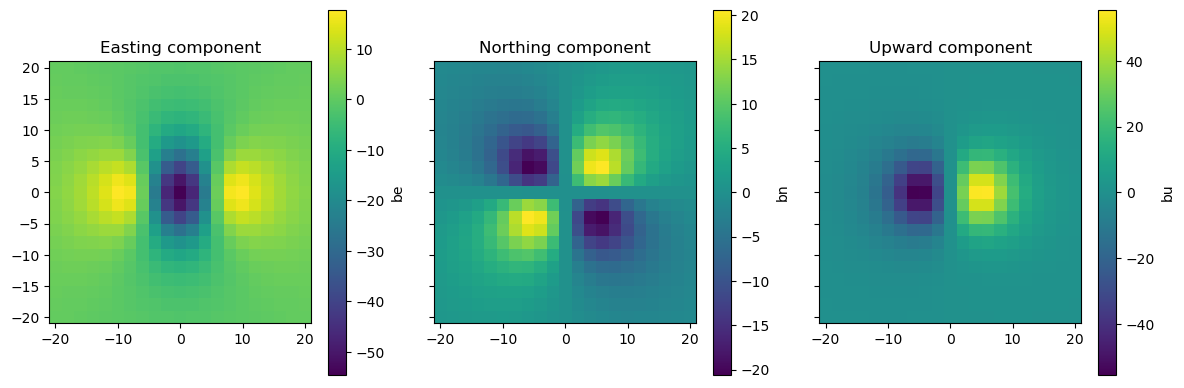

In [8]:
easting, northing = coordinates[:2]
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))

tmp = ax1.pcolormesh(easting, northing, be)
ax1.set_title("Easting component")
plt.colorbar(tmp, ax=ax1, label="be")

tmp = ax2.pcolormesh(easting, northing, bn)
ax2.set_title("Northing component")
plt.colorbar(tmp, ax=ax2, label="bn")

tmp = ax3.pcolormesh(easting, northing, bu)
ax3.set_title("Upward component")
plt.colorbar(tmp, ax=ax3, label="bu")

for ax in (ax1, ax2, ax3):
    ax.set_aspect("equal")

    
plt.tight_layout()
plt.show()

### Colourmaps of gravity components

In [9]:
ge, gn, gu = fnc.ellipsoid_gravity(coordinates, triaxial_example, density=2000)

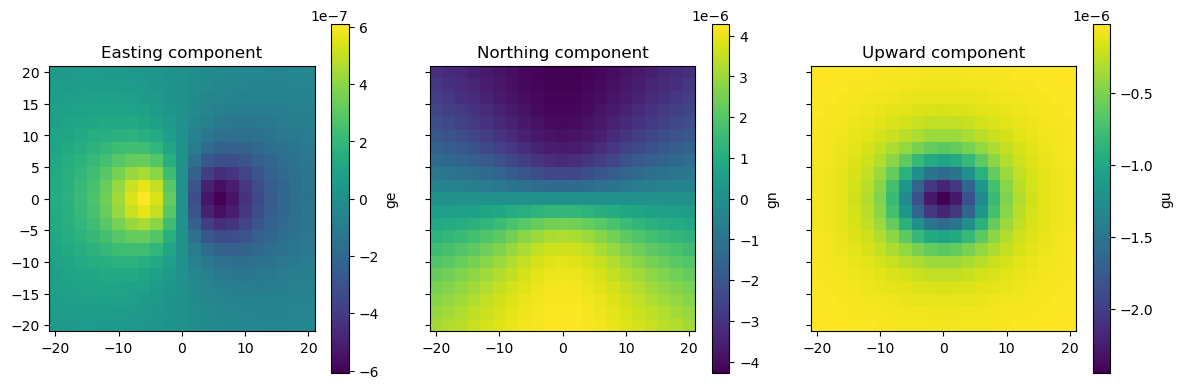

In [10]:
easting, northing = coordinates[:2]
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))

tmp = ax1.pcolormesh(easting, northing, ge)
ax1.set_title("Easting component")
plt.colorbar(tmp, ax=ax1, label="ge")

tmp = ax2.pcolormesh(easting, northing, gn)
ax2.set_title("Northing component")
plt.colorbar(tmp, ax=ax2, label="gn")

tmp = ax3.pcolormesh(easting, northing, gu)
ax3.set_title("Upward component")
plt.colorbar(tmp, ax=ax3, label="gu")

for ax in (ax1, ax2, ax3):
    ax.set_aspect("equal")

    
plt.tight_layout()
plt.show()

### Interactive ellipsoid 

<IPython.core.display.Javascript object>


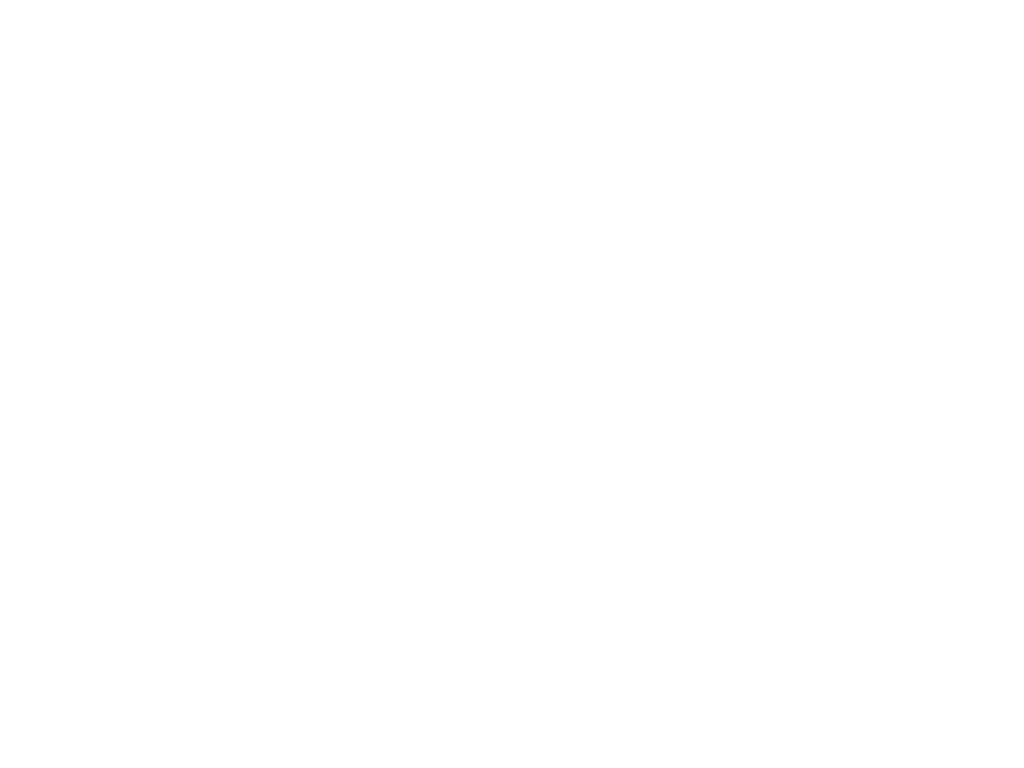

Text(0.5, 0, 'Upward')

In [11]:
%matplotlib notebook

V = fnc._get_v_as_euler(yaw, pitch, roll) # Euler rotation matrix
x1, y1, z1 = fnc._generate_basic_ellipsoid(a, b, c) # creates ellipsoid surface
local_coords = fnc._global_to_local(x1, y1, z1, 0, V) # rotates ellipsoid surface


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

max_radius = max(a, b, c)
for axis in 'xyz':
    getattr(ax, 'set_{}lim'.format(axis))((-max_radius, max_radius))
    
ax.plot_surface(x1, y1, z1, color='green', alpha=0.6)
ax.plot_surface(local_coords[0], local_coords[1], local_coords[2], color='blue', alpha=0.6)

legend_elements = [
    Patch(facecolor='green', edgecolor='k', label='Original'),
    Patch(facecolor='blue', edgecolor='k', label='Rotated')
]
ax.legend(handles=legend_elements)

ax.set_xlabel('Northing')
ax.set_ylabel('Easting')
ax.set_zlabel('Upward')

### Colourmap of upward gravity component 

In [12]:
e, n, u = coordinates

In [13]:
_, _, gu = fnc.ellipsoid_gravity(coordinates, triaxial_example, density=2000)

In [14]:
plt.pcolormesh(e, n, gu)
plt.gca().set_aspect("equal")
plt.colorbar(label="gz")
plt.title(f"Vertical gravity at constant height {u[0][0]}")
plt.xlabel("Easting")
plt.ylabel("Northing")

plt.show()

### Decay comparison of ellipsoid body and point mass

In [15]:
 # plot decay when moving along the z-axis

z = np.linspace(c, 10*c**2, 50)
x = y = np.zeros_like(z)

# lists to hold variables
gz = []
point_gz = []
density = 2000
# calculate ellipsoid mass
ellipsoid_mass =  density * 4/3 * np.pi * a * b * c


In [16]:
_, _, gu = fnc.ellipsoid_gravity((x, y, z), triaxial_example, density=density)

In [17]:
for i in range(len(x)):
        point_grav = pointgrav(x[i], y[i], z[i], 0, 0, 0, ellipsoid_mass)
        point_gz.append(point_grav)


<IPython.core.display.Javascript object>


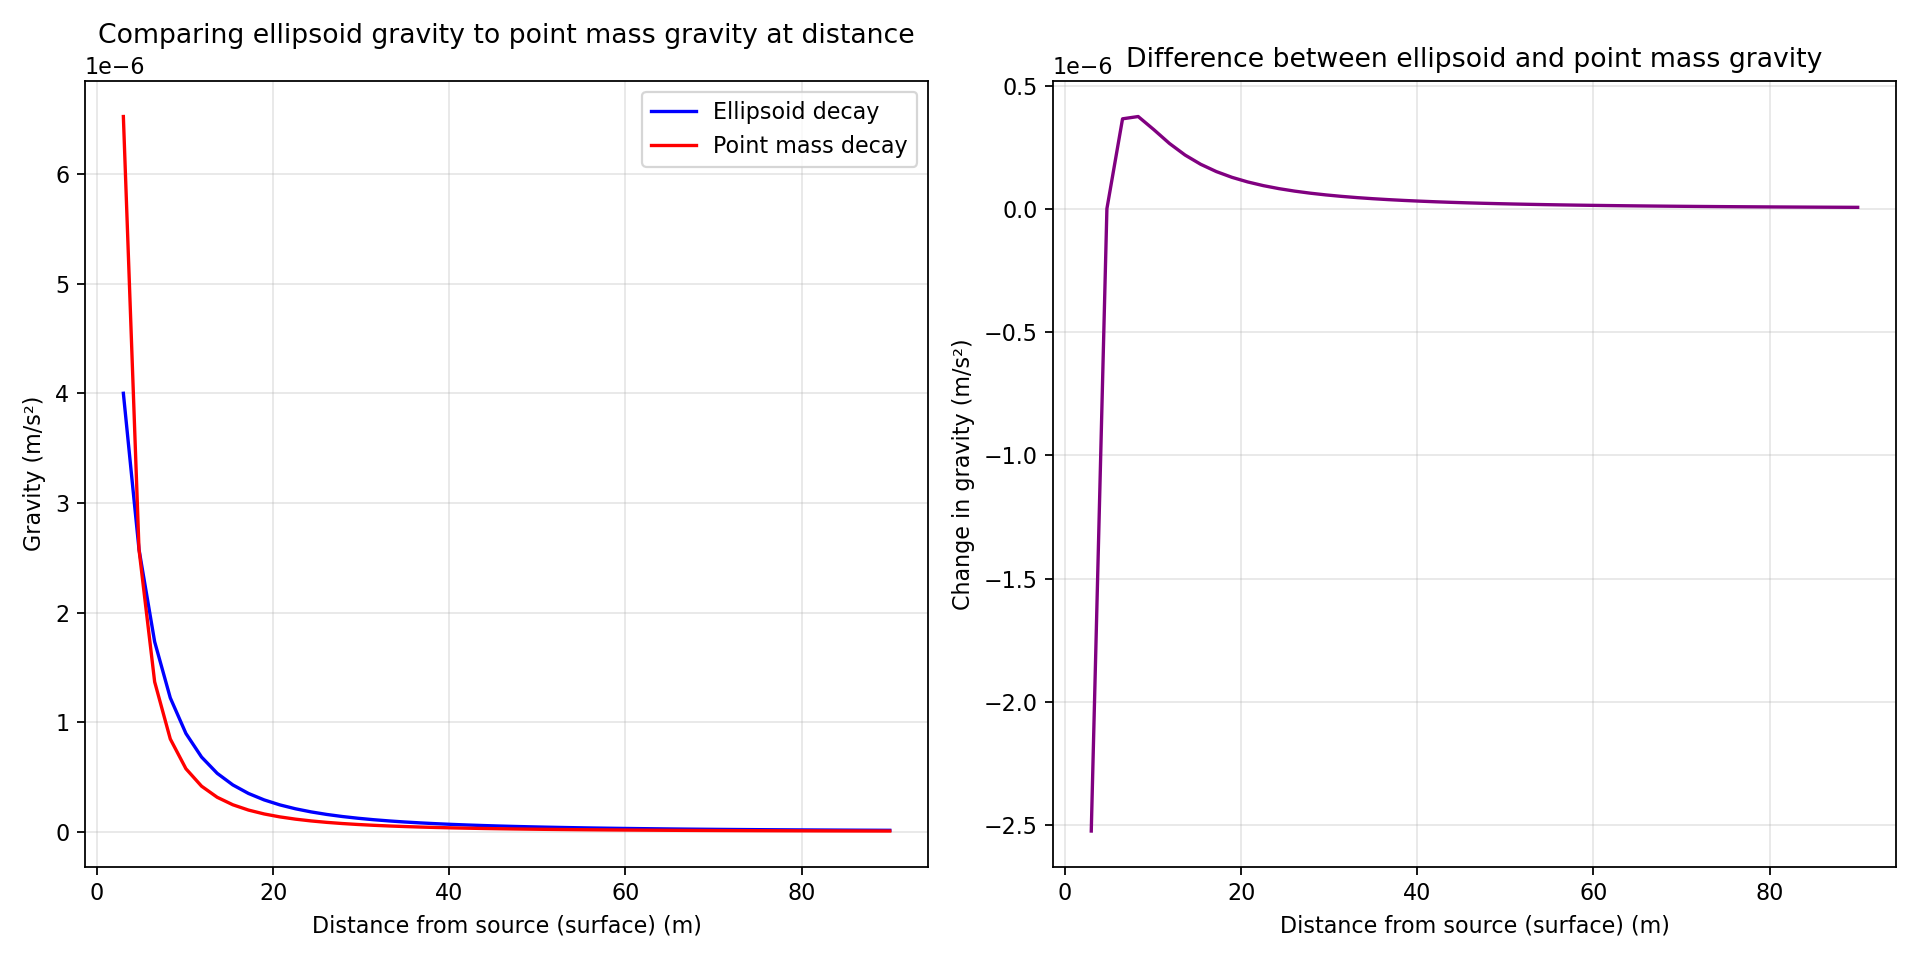

In [18]:
# plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

# plot 1: gravity decay of the two models
axs[0].set_title("Comparing ellipsoid gravity to point mass gravity at distance")
axs[0].plot(z, np.abs(gu), color='blue', label='Ellipsoid decay')
axs[0].plot(z, np.abs(point_gz), color='red', label='Point mass decay')
axs[0].set_ylabel('Gravity (m/s²)')
axs[0].set_xlabel('Distance from source (surface) (m)')
axs[0].legend()
axs[0].grid(alpha=0.3)

# plot 2: difference between the gravity models
axs[1].set_title("Difference between ellipsoid and point mass gravity")
axs[1].plot(z, np.abs(gu) - np.abs(point_gz), color='purple', label='Difference')
axs[1].set_xlabel('Distance from source (surface) (m)')
axs[1].set_ylabel('Change in gravity (m/s²)')
axs[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()